# 1. Importar librerías y cargar datos

In [1]:
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np

# Para preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Manejo de desbalance
from imblearn.over_sampling import SMOTE

# Métricas
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
# Cargar datos
# Asumiendo que el DataFrame se llama df
df = pd.read_csv('../datos/df_all_data.csv')

# 2.  Exploración inicial de datos

Comprobamos:
1. Presencia de valores Null.
2. Tipo de dato de las variables o características.

In [4]:
# Echar un vistazo a las primeras filas
print(df.head())

   paciente  num_slice      bg      el      ic       t set calidad  \
0  03170000          3 0.99956 0.87141 0.92278 0.60173   X    mala   
1  03170000          4 0.99969 0.95587 0.90189 0.87512   X   media   
2  03170000          5 0.99972 0.96712 0.98880 0.95881   X   buena   
3  03170000          6 0.99956 0.95546 0.98706 0.96104   X   buena   
4  03170000          7 0.99943 0.94567 0.98206 0.94283   X   buena   

   confianza LV  area bbox LV  confianza IC  area bbox IC  
0       0.64954         24275       0.82333         13183  
1       0.74838         23286       0.63448         13021  
2       0.91941         26557       0.91615         16125  
3       0.93057         29575       0.90004         18809  
4       0.97725         21910       0.97257         12095  


In [5]:
# Ver información general y tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   paciente      3459 non-null   object 
 1   num_slice     3459 non-null   int64  
 2   bg            3459 non-null   float64
 3   el            3459 non-null   float64
 4   ic            3459 non-null   float64
 5   t             3459 non-null   float64
 6   set           3459 non-null   object 
 7   calidad       3459 non-null   object 
 8   confianza LV  3459 non-null   float64
 9   area bbox LV  3459 non-null   int64  
 10  confianza IC  3459 non-null   float64
 11  area bbox IC  3459 non-null   int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 324.4+ KB


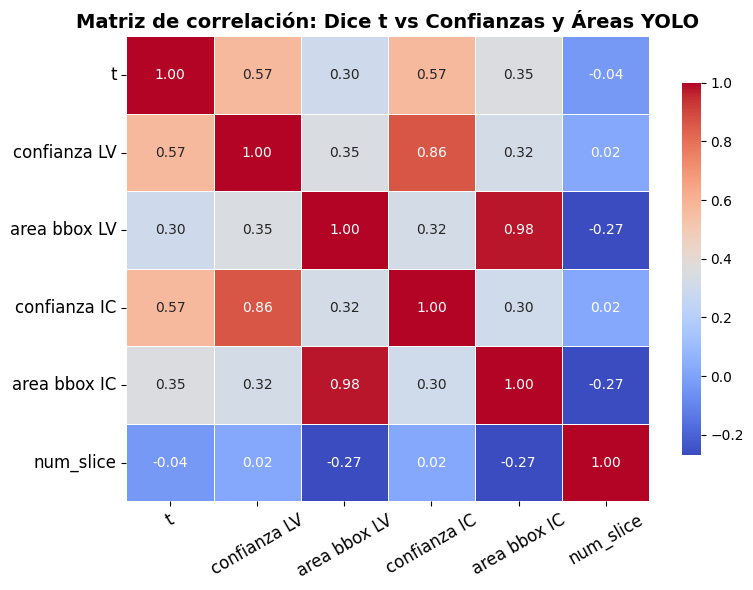

In [6]:
# Filtrar solo las columnas numéricas relevantes para el análisis
columnas_interes = ['t', 'confianza LV', 'area bbox LV', 'confianza IC', 'area bbox IC', 'num_slice']
df_corr = df[columnas_interes].copy()

# Calcular matriz de correlación
correlation_matrix = df_corr.corr()

# Visualizar la matriz con un heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de correlación: Dice t vs Confianzas y Áreas YOLO', fontsize=14, fontweight='bold')

# Aumentar tamaño de los ticks de los ejes
plt.xticks(fontsize=12, rotation=30)
plt.yticks(fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

In [7]:
df.drop(['bg', 'el', 'ic', 't', 'set'], axis = 1, inplace = True)

In [8]:
# Ver información general y tipos de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   paciente      3459 non-null   object 
 1   num_slice     3459 non-null   int64  
 2   calidad       3459 non-null   object 
 3   confianza LV  3459 non-null   float64
 4   area bbox LV  3459 non-null   int64  
 5   confianza IC  3459 non-null   float64
 6   area bbox IC  3459 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 189.3+ KB


In [10]:
'''
# Simulando el resultado de datos_diarios.info()
columns = df.columns.tolist()
non_null_counts = [3459, 3459, 3459, 3459, 3459, 3459, 3405, 3133, 3453, 3453, 3405, 3405, 3405, 3415, 3405, 3453, 3453, 3459]
total_entries = 3459

# Creando el DataFrame basado en los datos simulados
datos_faltantes = pd.DataFrame(index=columns, data={"Non-Null Count": non_null_counts})
datos_faltantes["Missing Count"] = total_entries - datos_faltantes["Non-Null Count"]

# Gráfico apilado con datos disponibles y faltantes
plt.figure(figsize=(12, 8))
plt.bar(datos_faltantes.index, datos_faltantes["Non-Null Count"], label="Datos Disponibles", color="green", edgecolor="black")
plt.bar(datos_faltantes.index, datos_faltantes["Missing Count"], bottom=datos_faltantes["Non-Null Count"],
        label="Datos Faltantes", color="red", edgecolor="black")

# Etiquetas y leyenda
plt.title("Comparación entre Datos Disponibles y Faltantes por Variable", fontsize=14)
plt.ylabel("Número de Datos", fontsize=12)
plt.xlabel("Variables", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
'''

'\n# Simulando el resultado de datos_diarios.info()\ncolumns = df.columns.tolist()\nnon_null_counts = [3459, 3459, 3459, 3459, 3459, 3459, 3405, 3133, 3453, 3453, 3405, 3405, 3405, 3415, 3405, 3453, 3453, 3459]\ntotal_entries = 3459\n\n# Creando el DataFrame basado en los datos simulados\ndatos_faltantes = pd.DataFrame(index=columns, data={"Non-Null Count": non_null_counts})\ndatos_faltantes["Missing Count"] = total_entries - datos_faltantes["Non-Null Count"]\n\n# Gráfico apilado con datos disponibles y faltantes\nplt.figure(figsize=(12, 8))\nplt.bar(datos_faltantes.index, datos_faltantes["Non-Null Count"], label="Datos Disponibles", color="green", edgecolor="black")\nplt.bar(datos_faltantes.index, datos_faltantes["Missing Count"], bottom=datos_faltantes["Non-Null Count"],\n        label="Datos Faltantes", color="red", edgecolor="black")\n\n# Etiquetas y leyenda\nplt.title("Comparación entre Datos Disponibles y Faltantes por Variable", fontsize=14)\nplt.ylabel("Número de Datos", fontsi

Vemos que para algunos atributos tenemos valores Null. Como tenemos muchas muestras y las que tienen algun valor Null son pocas, lo mejor será eliminarlas.

In [ ]:
df = df.dropna()

In [ ]:
df.info()

También vemos como todas las variables tienen el tipo de dato deseado:
- Variables numéricas son float o int.
- Variables categóricas (Fabricante, modelode máquina y variable objetivo) de tipo `object`.

# 3. División en características (X) y variable objetivo (y)

In [11]:
X = df.drop(columns = ['paciente','calidad'], axis=1)
y = df['calidad']

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_slice     3459 non-null   int64  
 1   confianza LV  3459 non-null   float64
 2   area bbox LV  3459 non-null   int64  
 3   confianza IC  3459 non-null   float64
 4   area bbox IC  3459 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 135.2 KB


# 4. Codificación One-hot - variables Dummy

Algunos de los métodos esembles que vamos a emplear no funcionan correctamente sobre variables categóricas, como es el caso de `RandomForest`. Por ello, introducimos variables dummy para codificar a las variables categóricas. Usamos la función `pandas.get_dummies()`. Pero antes, ponemos todos los valores de las   variables categóricas en minúscula.

In [ ]:
cat_cols = X.select_dtypes(include='object').columns
X[cat_cols] = X[cat_cols].apply(lambda x: x.str.lower())
variables_dummies = pd.get_dummies(X[cat_cols], drop_first = True, dummy_na = False)

# Eliminamos los atributos originales
X.drop(cat_cols, axis = 1, inplace = True)
# Concatenamos los nuevos atributos creados para las variables categóricas
X = pd.concat([X, variables_dummies], axis = 1)
# Mostramos como quedan los datos de nuevo.
X.head()

Como se puede apreciar, usamos el argumento `drop_first = True` para eliminar la primera de las columnas generadas para cada característica, con el objetivo de evitar la colinealidad (que una de las columnas sea combinación lineal de las demás). El número de características resultantes en el dataset es de 26.

# 5. División train - test

Separamos nuestros datos en un conjunto de entrenamiento y otro de prueba, de manera que las proporciones de las clases en la variable objetivo se mantengan (estratificación).

In [13]:
# Dividir entre train y test con estratificación (importante si la clase está desbalanceada)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Mantener la proporción de clases
)

# 6. Estudio de importancia de características

Muchas veces es útil hacer un análisis preliminar de qué features (columnas) tienen mayor impacto en la predicción, sobre todo con modelos de tipo `RandomForest` o `Gradient Boosting` que ofrecen una forma sencilla de obtener la importancia de cada variable.



## 6.1. Entrenar un modelo rápido de RandomForest

Aquí haremos un RandomForestClassifier sencillo (sin hacer GridSearch todavía), para obtener la importancia de características.

In [14]:
# Entrenamos un random forest básico
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obtener la importancia de las características
importances = rf.feature_importances_
features = X_train.columns

# Ordenamos de mayor a menor importancia
indices = np.argsort(importances)[::-1]

# Mostramos las importancias de forma ordenada
print("Importancia de características (RandomForest):")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]}: {importances[indices[i]]:.4f}")

Importancia de características (RandomForest):
1. confianza IC: 0.4132
2. confianza LV: 0.3813
3. area bbox IC: 0.0833
4. area bbox LV: 0.0766
5. num_slice: 0.0456


## 6.2. Descartar características

- Criterio: si ves que hay variables con importancia muy baja (por ejemplo, < 0.01 o un orden de magnitud menor que las demás), podrías considerar eliminarlas.
- Herramienta: podrías utilizar `SelectFromModel` para automatizar el proceso.

In [15]:
threshold=0.01

In [16]:
selector = SelectFromModel(rf, threshold=threshold, prefit=True)

# El selector crea una máscara booleana de las features seleccionadas
selected_features = selector.get_support(indices=True)

print(f"Variables por encima del umbral de {threshold}:")
print(selected_features)

# Podemos filtrar X_train, X_test
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]

Variables por encima del umbral de 0.01:
[0 1 2 3 4]


In [ ]:
X_train_selected.info()

# 7. Estudio de desbalanceo de clases - SMOTE

Comenzamos analizando si efectivamente tennemos desbalanceo de clases.



In [ ]:
print(y_train.value_counts())

In [ ]:
value_counts = y_train.value_counts()

# Crear el gráfico de barras con los valores directamente de value_counts
plt.figure(figsize=(8, 6))
bars = plt.bar(value_counts.index, value_counts.values, color=['red', 'green', 'blue'])

# Etiquetas y título
plt.xlabel('Clases', fontsize=16)
plt.ylabel('Número de casos', fontsize=16)
plt.title('Distribución de calidad de cortes en train dataset', fontsize=16)

# Añadir valores sobre las barras
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 5,  # Un poco por encima de la barra
             str(bar.get_height()),
             ha='center', va='bottom',
             fontsize=13, fontweight='bold')

# Ajustar tamaño de los ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

Efectivamente las clases "mala" y "buena" están en minoríarespecto a la clase "media".

## 7.1. Aplicamos SMOTE en conjunto de train - Opcional

sm = SMOTE(random_state=42)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
X_train_selected_smote, y_train_selected_smote = sm.fit_resample(X_train_selected, y_train)

print("Distribución original (train):\n", y_train.value_counts())
print("Distribución re-muestreada (train):\n", y_train_selected_smote.value_counts())

value_counts = y_train_selected_smote.value_counts()

# Crear el gráfico de barras con los valores directamente de value_counts
plt.figure(figsize=(8, 6))
bars = plt.bar(value_counts.index, value_counts.values, color=['red', 'green', 'blue'])

# Etiquetas y título
plt.xlabel('Concedido', fontsize=16)
plt.ylabel('Número de casos', fontsize=16)
plt.title('Distribución de concesión de crédito', fontsize=16)

# Añadir valores sobre las barras
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 5,  # Un poco por encima de la barra
             str(bar.get_height()),
             ha='center', va='bottom',
             fontsize=13, fontweight='bold')

# Ajustar tamaño de los ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mostrar el gráfico
plt.show()

X_train_selected.describe()

X_train_selected_smote.describe()

# 8. Estandarización estándar de datos de Train y Test Para algunos modelos

**Hay outliers en cuanto a área de bbox y RepetitionTime**, pero ese ruido lo vamos a disminuir aplicando StandardScaler antes de entrenar. Lo que hace StandardScaler es, para una característica $z_i$:

$$ z_i = \frac{x_i - \mu}{\sigma} $$
donde:
- $x_i$:  es el valor original de la i-ésima observación en una característica.
- $\mu$: es la media de esa característica.
- $\sigma$: es la desviación estándar de esa característica.

De esta manera, la característica transformada $z_i$ tiene media 0 y desviación estándar 1.

**NOTA: aplicaremos esta estandarización solamente a aquellos atributos que no sean probabilidades** 

In [ ]:
# Seleccionar todas las columnas numéricas
cols_numeric = X_train_selected.select_dtypes(include=['float64', 'int64']).columns

# Excluir las columnas que no queremos escalar
cols_to_scale = [col for col in cols_numeric if col not in ['confianza LV', 'confianza IC']]

# Aplicar StandardScaler solo a las columnas seleccionadas
scaler = StandardScaler()
scaled_array = scaler.fit_transform(X_train_selected[cols_to_scale])

# Crear un DataFrame con los datos escalados manteniendo el mismo índice y nombres de columnas
X_scaled = pd.DataFrame(scaled_array, columns=cols_to_scale, index=X_train_selected.index)

# Reemplazar las columnas originales por las escaladas
#X_train_selected_smote[cols_to_scale] = X_scaled

In [ ]:
X_scaled.describe()

**Debemos almacenar el objeto `StandardScaler` (entrenado en los datos de train) para aplicarlo a futuros casos desconocidos.**

In [ ]:
joblib.dump(scaler, 'scaler.pkl')

Ahora, para asegurarnos que ha ido bien, lo cargamos y se lo aplicamos a las características de test:

In [ ]:
# Carga el scaler
loaded_scaler = joblib.load('scaler.pkl')

In [ ]:
X_test_selected.info()

In [ ]:
# Seleccionar todas las columnas numéricas de X_test
X_test_num = X_test_selected.copy()  # O el DataFrame que estés utilizando

# Lista de columnas que NO queremos escalar
cols_excluir = ['confianza LV', 'confianza IC']

# Crear una lista de las columnas numéricas a escalar, excluyendo las no deseadas
cols_to_scale = [col for col in X_test_num.columns if col not in cols_excluir]

# Extraer el subconjunto del DataFrame con las columnas a escalar
X_test_num = X_test_num[cols_to_scale]

# Transformar usando el scaler ya entrenado
X_test_num_array = loaded_scaler.transform(X_test_num)

# Convertir de nuevo a DataFrame para conservar índices y nombres de columnas
X_test_num_scaled = pd.DataFrame(X_test_num_array, columns=cols_to_scale, index=X_test_num.index)

In [ ]:
X_test_num_scaled.describe()

# 9. Guardar datos preprocesados.

In [17]:
df_train = pd.concat([X_train_selected, y_train], axis=1)
df_train.head()

,num_slice,confianza LV,area bbox LV,confianza IC,area bbox IC,calidad
2899,4,0.75173,24785,0.69479,14388,media
2785,1,0.43567,18826,0.38825,8386,mala
2747,6,0.89355,29634,0.92248,18827,buena
1760,2,0.84642,32703,0.85547,21353,buena
3358,7,0.56057,16221,0.56743,6500,mala


In [18]:
df_train.to_csv('../datos/df_train.csv', index=False)

In [19]:
df_test = pd.concat([X_test_selected, y_test], axis=1)
df_test.head()

,num_slice,confianza LV,area bbox LV,confianza IC,area bbox IC,calidad
631,2,0.45833,23112,0.50968,12396,mala
1020,2,0.93172,25829,0.68261,15236,media
1149,3,0.63025,23289,0.51440,12963,media
710,7,0.77134,17793,0.87805,8515,buena
3228,11,0.60754,21690,0.70104,11054,mala


In [20]:
df_test.to_csv('../datos/df_test.csv', index=False)